# Compiled Sequential Importance Sampling

Compiled sequential importance sampling [1], or inference compilation, is a technique to amortize the computational cost of inference by learning a proposal distribution for importance sampling.

The proposal distribution is learned to minimise the KL divergence between the model and the guide, $\rm{KL}\!\left( p({\bf z} | {\bf x}) \lVert q_{\phi, x}({\bf z}) \right)$. This differs from variational inference, which would minimise $\rm{KL}\!\left( q_{\phi, x}({\bf z}) \lVert p({\bf z} | {\bf x}) \right)$. Using this loss encourages the approximate proposal distribution to be broader than the true posterior (mass covering), whereas variational inference typically learns a narrower approximation (mode seeking). Guides for importance sampling are usually desired to have heavier tails than the model (see this [stackexchange question](https://stats.stackexchange.com/questions/76798/in-importance-sampling-why-should-the-importance-density-have-heavier-tails)). Therefore, the inference compilation loss is usually more suited to compiling a guide for importance sampling.

Another benefit of CSIS is that, unlike many types of variational inference, it has no requirement that the model is differentiable. This allows it to be used for inference on arbitrarily complex programs (e.g. a Captcha renderer [1]).

This example shows CSIS being used to speed up inference on a simple problem with a known analytic solution.

In [1]:
import torch
import torch.nn as nn
import torch.functional as F

import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim

import os
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

### Specify the model:

The model is specified in the same way as any Pyro model, except that a keyword argument, `observations`, must be used to input a dictionary with each observation as a key. Since inference compilation involves learning to perform inference for any observed values, it is not important what the values in the dictionary are. `0` is used here.

In [2]:
def model(prior_mean, observations={"x1": 0, "x2": 0}):
    x = pyro.sample("z", dist.Normal(prior_mean, torch.tensor(5**0.5)))
    y1 = pyro.sample("x1", dist.Normal(x, torch.tensor(2**0.5)), obs=observations["x1"])
    y2 = pyro.sample("x2", dist.Normal(x, torch.tensor(2**0.5)), obs=observations["x2"])
    return x

### And the guide:

The guide will be trained (a.k.a. compiled) to use the observed values to make proposal distributions for each unconditioned `sample` statement. In the paper [1], a neural network architecture is automatically generated for any model. However, for the implementation in Pyro the user must specify a task-specific guide program structure. As with any Pyro guide function, this should have the same call signature as the model. It must also encounter the same unobserved `sample` statements as the model. So that the guide program can be trained to make good proposal distributions, the distributions at `sample` statements should depend on the values in `observations`. In this example, a feed-forward neural network is used to map the observations to a proposal distribution for the latent variable.

`pyro.module` is called when the guide function is run so that the guide parameters can be found by the optimiser during training.

In [3]:
class Guide(nn.Module):
    def __init__(self):
        super().__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 2))

    def forward(self, prior_mean, observations={"x1": 0, "x2": 0}):
        pyro.module("guide", self)
        x1 = observations["x1"]
        x2 = observations["x2"]
        v = torch.cat((x1.view(1, 1), x2.view(1, 1)), 1)
        v = self.neural_net(v)
        mean = v[0, 0]
        std = v[0, 1].exp()
        pyro.sample("z", dist.Normal(mean, std))

guide = Guide()

### Now create a `CSIS` instance:
The object is initialised with the model; the guide; a PyTorch optimiser for training the guide; and the number of importance-weighted samples to draw when performing inference. The guide will be optimised for a particular value of the model/guide argument, `prior_mean`, so we use the value set here throughout training and inference.

In [4]:
optimiser = pyro.optim.Adam({'lr': 1e-3})
csis = pyro.infer.CSIS(model, guide, optimiser, num_inference_samples=50)
prior_mean = torch.tensor(1.)

### Now we 'compile' the instance to perform inference on this model:
The arguments given to `csis.step` are passed to the model and guide when they are run to evaluate the loss.

In [5]:
for step in range(n_steps):
    csis.step(prior_mean)

### And now perform inference by importance sampling:

The compiled guide program should now be able to propose a distribution for `z` that approximates the posterior, $p(z | x_1, x_2)$, for any $x_1, x_2$. The same `prior_mean` is entered again, as well as the observed values inside `observations`.

In [6]:
posterior = csis.run(prior_mean,
                     observations={"x1": torch.tensor(8.),
                                   "x2": torch.tensor(9.)})
marginal = pyro.infer.EmpiricalMarginal(posterior, "z")

### We now plot the results and compare with importance sampling:

We observe $x_1 = 8$ and $x_2 = 9$. Inference is performed by taking 50 samples using CSIS, and 50 using importance sampling from the prior. We then plot the resulting approximations to the posterior distributions, along with the analytic posterior.

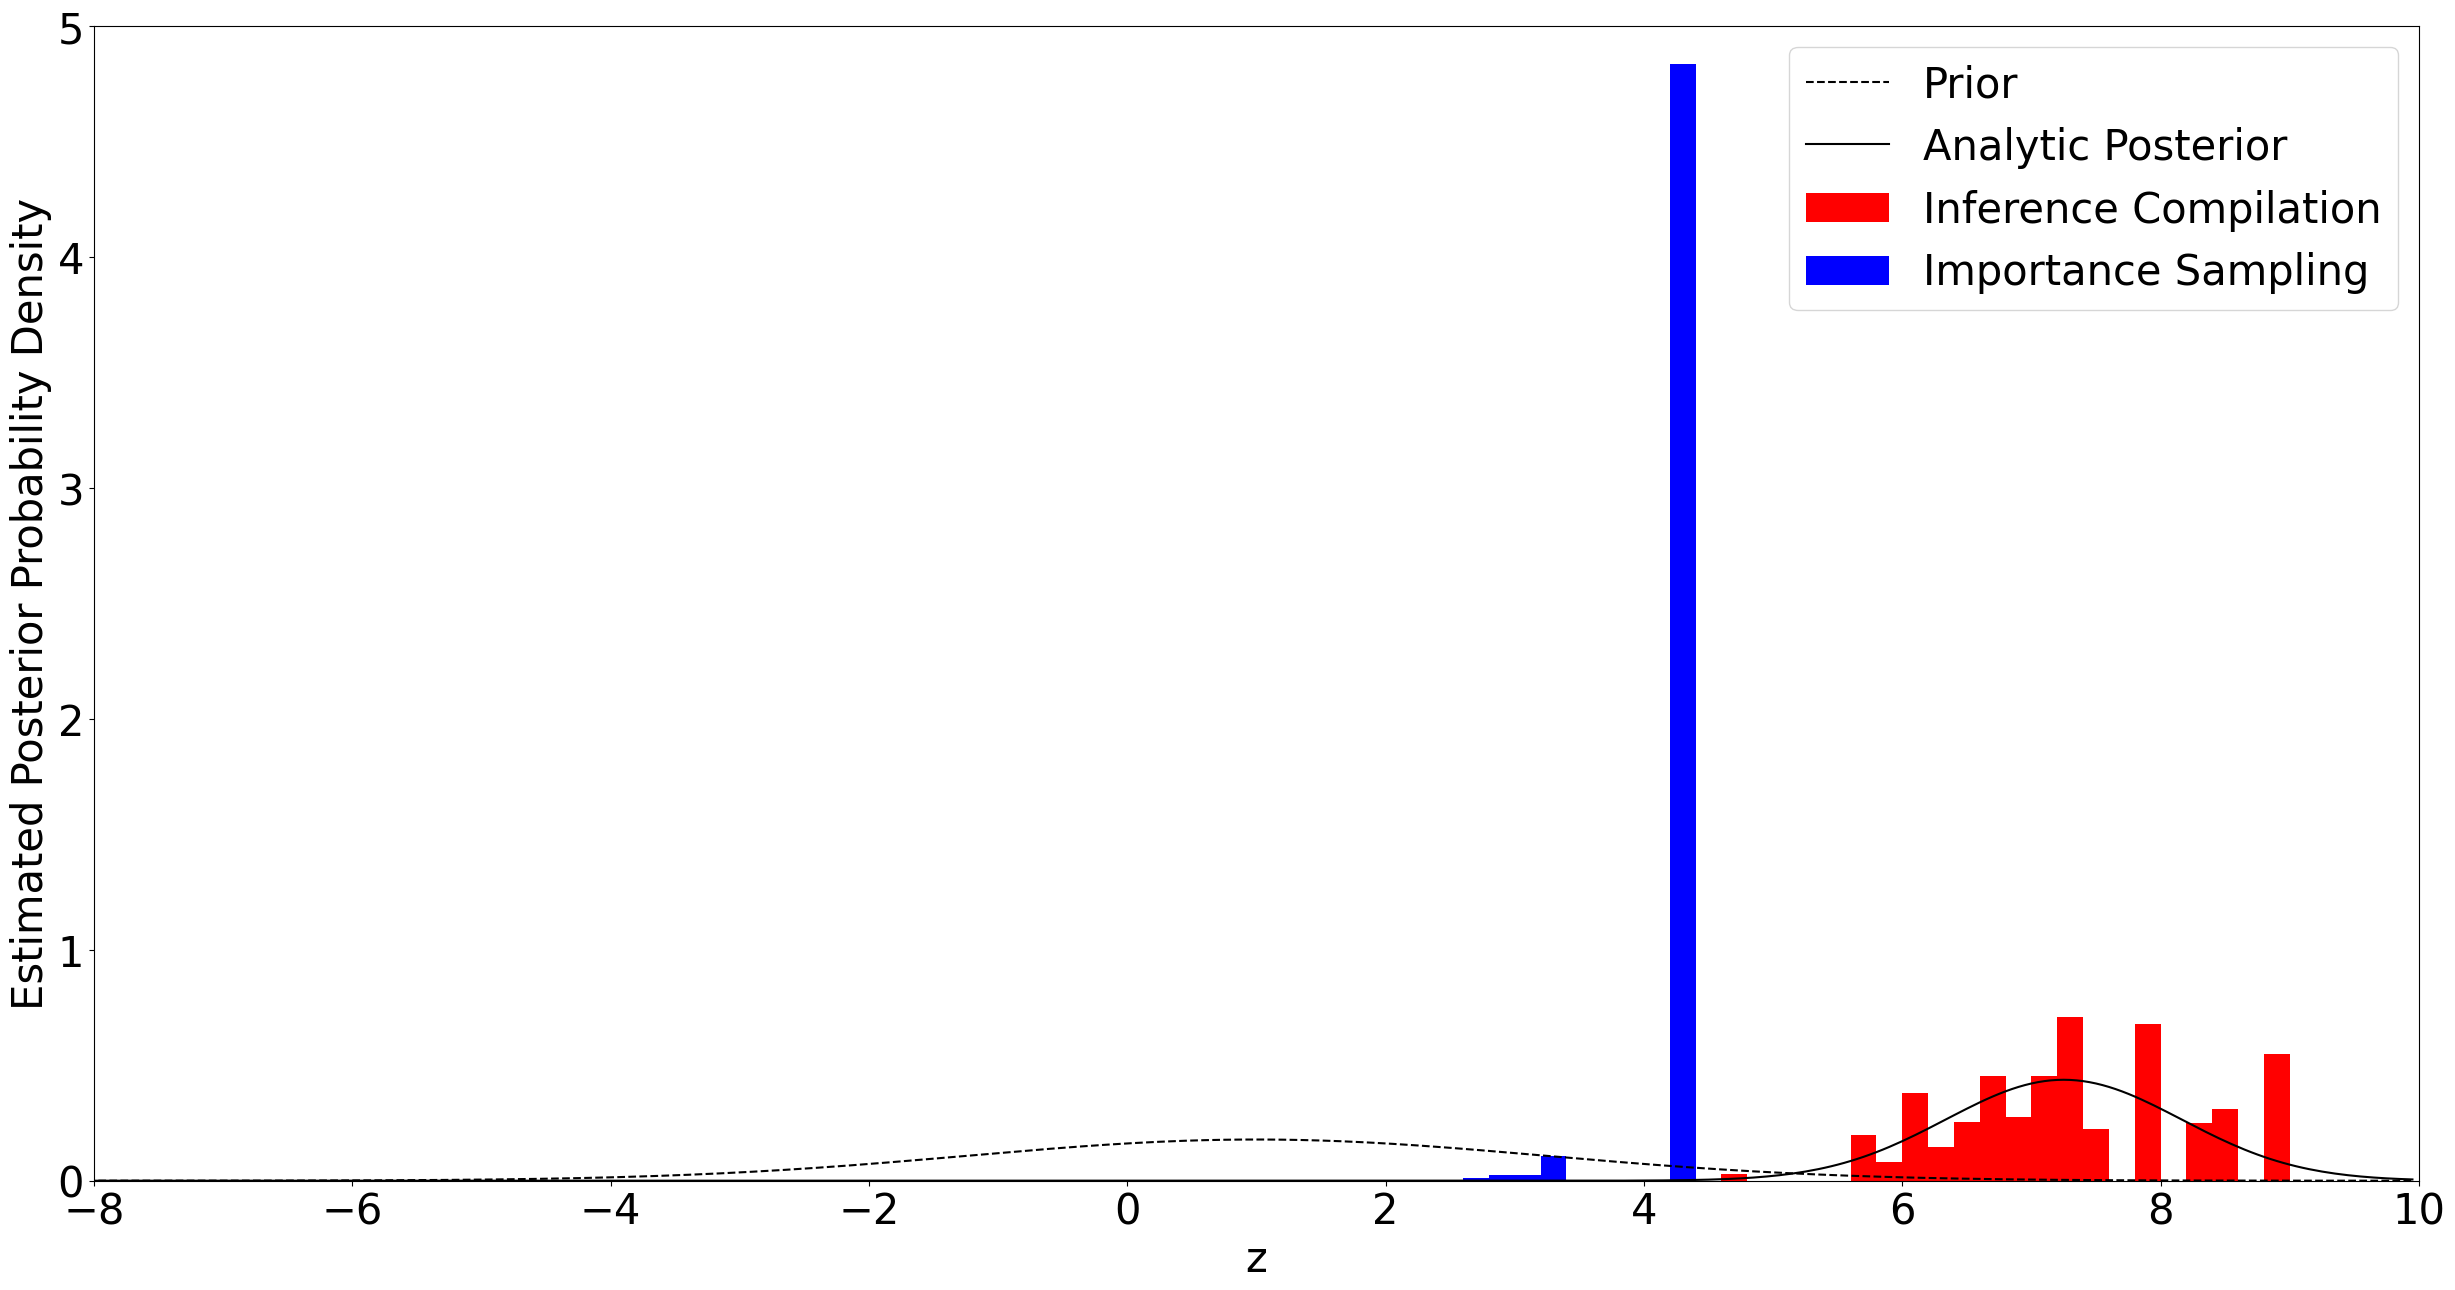

In [7]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

with torch.no_grad():
    # Draw samples from empirical marginal for plotting
    csis_samples = torch.stack([marginal() for _ in range(1000)])

    # Calculate empirical marginal with importance sampling
    is_posterior = pyro.infer.Importance(model, num_samples=50).run(
        prior_mean, observations={"x1": torch.tensor(8.),
                                  "x2": torch.tensor(9.)})
    is_marginal = pyro.infer.EmpiricalMarginal(is_posterior, "z")
    is_samples = torch.stack([is_marginal() for _ in range(1000)])

# Calculate true prior and posterior over z
true_posterior_z = torch.arange(-10, 10, 0.05)
true_posterior_p = dist.Normal(7.25, (5/6)**0.5).log_prob(true_posterior_z).exp()
prior_z = true_posterior_z
prior_p = dist.Normal(1., 5**0.5).log_prob(true_posterior_z).exp()

plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots()
plt.plot(prior_z, prior_p, 'k--', label='Prior')
plt.plot(true_posterior_z, true_posterior_p, color='k', label='Analytic Posterior')
plt.hist(csis_samples.numpy(), range=(-10, 10), bins=100, color='r', density=1,
         label="Inference Compilation")
plt.hist(is_samples.numpy(), range=(-10, 10), bins=100, color='b', density=1,
         label="Importance Sampling")
plt.xlim(-8, 10)
plt.ylim(0, 5)
plt.xlabel("z")
plt.ylabel("Estimated Posterior Probability Density")
plt.legend()
plt.show()

Using $x_1 = 8$ and $x_2 = 9$ gives a posterior far from the prior, and so using the prior as a guide for importance sampling is inefficient, giving a very small effective sample size. By first learning a suitable guide function, CSIS has a proposal distribution much more closely matched to the true posterior. This allows samples to be drawn with far better coverage of the true posterior, and greater effective sample size, as shown in the graph above.

For other examples of inference compilation, see [1] or <https://github.com/probprog/anglican-infcomp-examples>.

## References

[1] `Inference compilation and universal probabilistic programming`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Tuan Anh Le, Atilim Gunes Baydin, and Frank Wood